# Part I: Pytorch mnist demo
In this part, we will demonstrate the usage of pytorch and sklearn.

The target data is MNIST.

## 1.1. import what u need


In [3]:
input_data = npy.load('train.npy')
input_label = pd.read_csv('train.csv')
print(input_label['label'][input_label['image_id'][3299]])

1


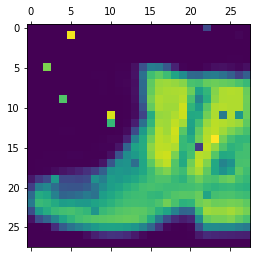

In [14]:
test_vec = input_data[29999,:]
test_matrix = test_vec.reshape(28,28)

# print(test_matrix.shape)
# print(test_matrix)
plt.matshow(test_matrix)
plt.show()

In [1]:
import torch     
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import copy
from sklearn.metrics import accuracy_score,f1_score,roc_curve,precision_recall_curve,average_precision_score,auc
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix,matthews_corrcoef,roc_auc_score
import matplotlib.pyplot as plt
import torch.utils.data as data
import numpy as npy
import pandas as pd

## 1.2. data preprocessing


In [10]:
BATCH_SIZE = 32

#加载torchvision包内内置的MNIST数据集 这里涉及到transform:将图片转化成torchtensor
train_dataset = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor())

#加载小批次数据，即将MNIST数据集中的data分成每组batch_size的小块，shuffle指定是否随机读取
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz
100%|█████████▉| 9904128/9912422 [01:25<00:00, 169162.21it/s]Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz

 57%|█████▋    | 16384/28881 [00:00<00:00, 71384.92it/s]
32768it [00:00, 43646.42it/s]
0it [00:00, ?it/s]Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz

 16%|█▌        | 262144/1648877 [00:03<00:14, 92508.18it/s]
9920512it [01:30, 110226.47it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/royubuntu/.local/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter

In [11]:
#定义网络模型亦即Net 这里定义一个简单的全连接层784->10
class Model(nn.Module):
    # def __init__(self):
    #     super(Model,self).__init__()
    #     self.linear1 = nn.Linear(784,784)
    #     self.linear2 = nn.Linear(784,10)
    # def forward(self,X):
    #     X = F.relu(self.linear1(X))
    #     return F.relu(self.linear2(X))

    # def __init__(self):
    #     super(Model,self).__init__()
    #     self.linear1 = nn.Linear(784,784)
    #     self.linear2 = nn.Linear(784,784)
    #     self.linear3 = nn.Linear(784,10)
    # def forward(self,X):
    #     X = F.relu(self.linear1(X))
    #     X = F.relu(self.linear2(X))
    #     return F.relu(self.linear3(X))
    # def __init__(self):
    #     super(Model,self).__init__()
    #     self.linear1 = nn.Linear(784,784)
    #     self.linear2 = nn.Linear(784,10)
    # def forward(self,X):
    #     X = F.relu(self.linear1(X))
    #     return F.relu(self.linear2(X))

    # def __init__(self):
    #     super(Model,self).__init__()
    #     self.linear1 = nn.Linear(784,784)
    #     self.linear2 = nn.Linear(784,784)
    #     self.linear3 = nn.Linear(784,10)
    # def forward(self,X):
    #     X = F.relu(self.linear1(X))
    #     X = F.relu(self.linear2(X))
    #     return F.relu(self.linear3(X))
    def __init__(self):
        super(Model,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
 
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [19]:
model = Model().cuda() #实例化卷积层
loss = nn.CrossEntropyLoss() #损失函数选择，交叉熵函数
optimizer = optim.SGD(model.parameters(),lr = 0.1)
num_epochs = 3

## 1.2. Train


In [21]:
losses = [] 
acces = []
eval_losses = []
eval_acces = []

for echo in range(num_epochs):
    train_loss = 0   #定义训练损失
    train_acc = 0    #定义训练准确度
    model.train()    #将网络转化为训练模式
    for i,(X,label) in enumerate(train_loader):     #使用枚举函数遍历train_loader
        #X = X.view(-1,784)       #X:[64,1,28,28] -> [64,784]将X向量展平
        X = Variable(X).cuda()          #包装tensor用于自动求梯度
        label = Variable(label).cuda()
        out = model(X)           #正向传播
        lossvalue = loss(out,label)         #求损失值
        optimizer.zero_grad()       #优化器梯度归零
        lossvalue.backward()    #反向转播，刷新梯度值
        optimizer.step()        #优化器运行一步，注意optimizer搜集的是model的参数
        
        #计算损失
        train_loss += float(lossvalue)      
        #计算精确度
        _,pred = out.max(1)
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    print("echo:"+' ' +str(echo))
    print("lose:" + ' ' + str(train_loss / len(train_loader)))
    print("accuracy:" + ' '+str(train_acc / len(train_loader)))

echo: 0
lose: 0.03387198359370232
accuracy: 0.9894
echo: 1
lose: 0.02665811014175415
accuracy: 0.9916333333333334
echo: 2
lose: 0.023606363797187804
accuracy: 0.9923


## 1.3. Test


In [15]:
# eval_loss = 0
# eval_acc = 0
label_all = None
pred_all = None
pred_pro_all = None
model.eval() #模型转化为评估模式
for X,label in test_loader:
    #X = X.view(-1,784)
    X = Variable(X)#.cuda()
    label = Variable(label)#.cuda()
    testout = model(X)
    testloss = loss(testout,label)
    #eval_loss += float(testloss)

    _, pred = testout.max(1)
    if label_all is None:
        label_all = label
    else:
        label_all = torch.cat([label_all,label])

    if pred_all is None:
        pred_all = torch.cat([pred])
    else:
        pred_all = torch.cat([pred_all,pred])

    if pred_pro_all is None:
        pred_pro_all = torch.cat([F.sigmoid(testout)])
    else:
        pred_pro_all = torch.cat([pred_pro_all,F.sigmoid(testout)])
#     num_correct = (pred == label).sum()
#     acc = int(num_correct) / X.shape[0]
#     eval_acc += acc

y_test = label_all.cpu().detach().numpy()
#print(y_test)
y_pred = pred_all.cpu().detach().numpy()
#print(y_pred)
y_pred_pro = pred_pro_all.cpu().detach().numpy()

In [16]:
print('ACC:%.7f' %accuracy_score(y_true=y_test, y_pred=y_pred))
print('Precision-macro:%.7f' %precision_score(y_true=y_test, y_pred=y_pred,average='macro'))
print('Recall-macro:%.7f' %recall_score(y_true=y_test, y_pred=y_pred,average='macro'))
print('F1-macro:%.7f' %f1_score(y_true=y_test, y_pred=y_pred,average='macro'))       

ACC:0.9862000
Precision-macro:0.9864398
Recall-macro:0.9857680
F1-macro:0.9860304


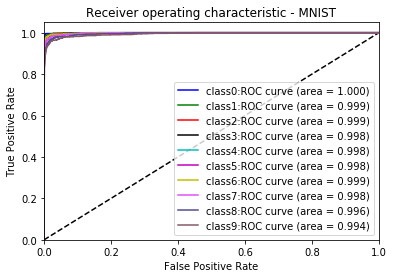

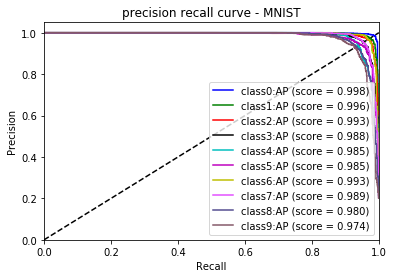

In [17]:
fpr = dict()
tpr = dict()
roc_auc = dict()
average_precision = dict()
recall = dict()
precision = dict()
for i in range(10):
    y_test2 = copy.deepcopy(y_test)
    y_test2[y_test2!=i] = 10
    y_test2[y_test2==i] = 1
    y_test2[y_test2==10] = 0
    y_pred_pro2 = y_pred_pro[:,i]
    #print(y_pred_pro2)
    #print(y_test2)
    fpr[i], tpr[i], _ = roc_curve(y_test2, y_pred_pro2)
    roc_auc[i] = roc_auc_score(y_test2,y_pred_pro2)


    average_precision[i] = average_precision_score(y_test2, y_pred_pro2)
    #print('Average precision-recall score: %.7f' % average_precision)
    precision[i], recall[i], _ = precision_recall_curve(y_test2,y_pred_pro2)

# Plot of a ROC curve for a specific class
colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868']
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - MNIST')
for i in range(10):
    plt.plot(fpr[i], tpr[i], label="class" + str(i) + ':ROC curve (area = %0.3f)' % roc_auc[i],color=colors[i])
plt.legend(loc="lower right")
#plt.savefig("roc.png")


# Plot of a ROC curve for a specific class
colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868']
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('precision recall curve - MNIST')
for i in range(10):
    plt.plot(recall[i], precision[i], label="class" + str(i) + ':AP (score = %0.3f)' % average_precision[i],color=colors[i])
plt.legend(loc="lower right")
#plt.savefig("pro.png")